## Dataset creation
In this pipeline we will build the final dataset that will be used for classificaiton
- Balance the dataset on repos, datas and labels 
- Create issue msg (prompt)
- Create issue embedding
- Create training ad testing split

In [ ]:
import os

os.chdir("..")
os.getcwd()

In [1]:
import pandas as pd
from datasets import load_dataset

ds = load_dataset("Eathus/cwe_view1003_raw_list", split="train")
cwe_1003_df = ds.to_pandas()

ds = load_dataset("Eathus/github-issues-references-max", split="train")
positive_df = ds.to_pandas()
display(positive_df.columns)
print(len(positive_df))

ds = load_dataset("Eathus/github-issues-negatives-max", split="train")
negative_df = ds.to_pandas()

positive_df.issue_owner_repo = positive_df.issue_owner_repo.map(tuple)
negative_df.issue_owner_repo = negative_df.issue_owner_repo.map(tuple)

negative_df = negative_df[
    ~negative_df.issue_github_id.isin(positive_df.issue_github_id)
]

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_cwe_list',
       'cve_primary_cwe', 'url', 'cve_tags', 'domain', 'issue_owner_repo',
       'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number',
       '__index_level_0__'],
      dtype='object')

6443


train-00001-of-00015.parquet:  92%|#########1| 157M/171M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/162M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/159M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/168M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3599385 [00:00<?, ? examples/s]

In [2]:
negative_df["issue_created_at"] = pd.to_datetime(
    negative_df["issue_created_at"], format="%Y-%m-%dT%H:%M:%SZ"
)
positive_df["issue_created_at"] = pd.to_datetime(
    positive_df["issue_created_at"], format="%Y-%m-%dT%H:%M:%SZ"
)

Let's reduce the time window of the issues in the negative dataset. The positive dataset it's made from references created between 01/01/2019 and 01/03/2025. It's so possible to thing that tracking issues created in that period are correctly tracked. 

In this way we want to reduce the chance of untracked issues that are not present in the references list  

In [3]:
import datetime

start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2025, 3, 1)

negative_df = negative_df[
    (negative_df.issue_created_at > start_date)
    & (negative_df.issue_created_at < end_date)
]

In [4]:
print(len(negative_df))
print(len(negative_df.drop_duplicates('issue_github_id')))

2232312
1926062


Let's also remove all the repos that have a too small presence in the negative dataset

In [5]:
vc = negative_df.issue_owner_repo.value_counts()
repos = vc[vc > 75].index

In [36]:
ds = load_dataset("Eathus/github-issues-references-max", split="train")
positive_df = ds.to_pandas()
positive_df.issue_owner_repo = positive_df.issue_owner_repo.map(tuple)
positive_df["issue_created_at"] = pd.to_datetime(
    positive_df["issue_created_at"], format="%Y-%m-%dT%H:%M:%SZ"
)

In [16]:
positive_df[positive_df['issue_github_id'] == 1749279355]

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_cwe_list,cve_primary_cwe,url,cve_tags,...,issue_body,issue_title,issue_comments_url,issue_comments_count,issue_created_at,issue_updated_at,issue_html_url,issue_github_id,issue_number,__index_level_0__
5285,CVE-2023-36189,2023-07-06T14:15:10.707,SQL injection vulnerability in langchain befor...,"{'cvssMetricV2': None, 'cvssMetricV30': None, ...","[{'source': 'cve@mitre.org', 'tags': None, 'ur...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,[89],89,https://github.com/hwchase17/langchain/issues/...,[Exploit],...,### System Info\r\n\r\nThere is no safeguard i...,SQLDatabaseChain has SQL injection issue,https://api.github.com/repos/langchain-ai/lang...,7,2023-06-09T07:19:24Z,2024-03-13T16:12:29Z,https://github.com/langchain-ai/langchain/issu...,1749279355,5923,5375
5286,CVE-2023-36189,2023-07-06T14:15:10.707,SQL injection vulnerability in langchain befor...,"{'cvssMetricV2': None, 'cvssMetricV30': None, ...","[{'source': 'cve@mitre.org', 'tags': None, 'ur...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,[89],89,https://github.com/langchain-ai/langchain/issu...,None,...,### System Info\r\n\r\nThere is no safeguard i...,SQLDatabaseChain has SQL injection issue,https://api.github.com/repos/langchain-ai/lang...,7,2023-06-09T07:19:24Z,2024-03-13T16:12:29Z,https://github.com/langchain-ai/langchain/issu...,1749279355,5923,5376


In [37]:
def filter_group(group):
    if group['cve_primary_cwe'].nunique() == 1:
        # All values of x are the same — keep the one with the latest publish_date
        return group.loc[[group['cve_published'].idxmax()]]
    else:
        # Conflicting x values — drop them all
        return pd.DataFrame()

filtered_positive_df = positive_df.groupby('issue_github_id', group_keys=False).apply(filter_group)

/tmp/ipykernel_37055/1655261174.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_positive_df = positive_df.groupby('issue_github_id', group_keys=False).apply(filter_group)


In [39]:
len(filtered_positive_df)
filtered_positive_df = filtered_positive_df[filtered_positive_df.issue_owner_repo.isin(repos)]
len(filtered_positive_df)

3675

In [28]:
print(len(positive_df))
negative_df = negative_df[negative_df.issue_owner_repo.isin(repos)]
positive_df = positive_df[positive_df.issue_owner_repo.isin(repos)]
print(len(positive_df))
print(len(positive_df.drop_duplicates('issue_github_id')))
print(len(positive_df.drop_duplicates(['issue_github_id', 'cve_id'])))

duplicate_counts = positive_df['issue_github_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print("Duplicate counts per issue_github_id:")
display(duplicate_counts)

duplicate_counts = positive_df[['issue_github_id', 'cve_id']].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print("Duplicate counts per issue_github_id:")

display(duplicate_counts)

6443
3761
3685
3726
Duplicate counts per issue_github_id:


issue_github_id
549961224     13
541977765      8
547887727      7
544834443      7
1575129238     4
1403710408     3
808144219      3
1279489454     3
555385999      3
1747393600     2
1243868852     2
405370167      2
1749279355     2
770111636      2
641764976      2
503095531      2
470163532      2
1998710063     2
2057585750     2
2755317359     2
2755404584     2
992843529      2
2371350372     2
1646878719     2
2758546837     2
1709938318     2
1676085284     2
1366329471     2
1054644643     2
2099860835     2
1038244979     2
1668648319     2
1184433000     2
1423542761     2
544355271      2
686885373      2
1648637134     2
1743120578     2
466729928      2
393762774      2
623816560      2
1229239444     2
2582440109     2
Name: count, dtype: int64

Duplicate counts per issue_github_id:


issue_github_id  cve_id          
1575129238       CVE-2023-26750      4
1403710408       CVE-2022-37616      3
555385999        CVE-2016-1000027    3
808144219        CVE-2021-43616      3
1279489454       CVE-2022-40734      3
1423542761       CVE-2023-30172      2
2755404584       CVE-2024-13135      2
2755317359       CVE-2024-13132      2
1366329471       CVE-2022-40468      2
2371350372       CVE-2024-6526       2
541977765        CVE-2019-20009      2
2099860835       CVE-2024-0962       2
992843529        CVE-2023-29824      2
2057585750       CVE-2024-8947       2
623816560        CVE-2020-26880      2
1038244979       CVE-2021-43398      2
1998710063       CVE-2024-8946       2
503095531        CVE-2020-25663      2
1054644643       CVE-2021-44079      2
1243868852       CVE-2023-25399      2
1229239444       CVE-2022-34037      2
770111636        CVE-2020-22083      2
466729928        CVE-2019-17371      2
1676085284       CVE-2023-35866      2
1743120578       CVE-2023-5171

In [27]:
inconsistent_mask = (
    positive_df
    .groupby('issue_github_id')['cve_primary_cwe']
    .transform(lambda x: x.nunique() > 1)  # True if 'primary_cwe' varies in the group
)
display(list(positive_df
    .groupby('issue_github_id')['cve_primary_cwe']))

# Step 2: Get the inconsistent duplicates (for inspection)
inconsistent_duplicates = positive_df[inconsistent_mask].sort_values('issue_github_id')

# Step 3: Drop duplicates ONLY where 'primary_cwe' is inconsistent
# (Keep first occurrence where duplicates have the same 'primary_cwe')
consistent_deduped = (
    positive_df
    .sort_values('cve_primary_cwe')  # Optional: Sort to prioritize certain CWE values
    .drop_duplicates(
        subset='issue_github_id',
        keep='first'
    )
)
print(f"Original length: {len(positive_df)}")
print(f"After dropping inconsistent duplicates: {len(consistent_deduped)}")

strict_deduped = positive_df[~inconsistent_mask]
print(len(strict_deduped))

[(128365381,
  143    125
  Name: cve_primary_cwe, dtype: object),
 (128365398,
  144    125
  Name: cve_primary_cwe, dtype: object),
 (151080998,
  488    335
  Name: cve_primary_cwe, dtype: object),
 (248590588,
  39    400
  Name: cve_primary_cwe, dtype: object),
 (249233709,
  38    400
  Name: cve_primary_cwe, dtype: object),
 (257947117,
  1041    476
  Name: cve_primary_cwe, dtype: object),
 (337760000,
  242    674
  Name: cve_primary_cwe, dtype: object),
 (351251936,
  71    787
  Name: cve_primary_cwe, dtype: object),
 (351978078,
  103    400
  Name: cve_primary_cwe, dtype: object),
 (390618242,
  7    787
  Name: cve_primary_cwe, dtype: object),
 (391351147,
  81    476
  Name: cve_primary_cwe, dtype: object),
 (391352422,
  82    125
  Name: cve_primary_cwe, dtype: object),
 (391610142,
  627    770
  Name: cve_primary_cwe, dtype: object),
 (391773951,
  83    401
  Name: cve_primary_cwe, dtype: object),
 (393636374,
  8    119
  Name: cve_primary_cwe, dtype: object),
 (39

Original length: 903
After dropping inconsistent duplicates: 866
866


Now we want to redice the dimension of the negative part of the dataset. One way it's to set a limit of maximum 1200 issues for each repo (the maximum number of reference per repo is 200)

In [29]:
negative_df.issue_owner_repo.count(), positive_df.issue_owner_repo.count()

(2211381, 3761)

In [41]:
positive_df = filtered_positive_df

In [33]:
filtered_negative_df = None
ratio = 5

for index, value in zip(
    positive_df.issue_owner_repo.value_counts().index,
    positive_df.issue_owner_repo.value_counts(),
):
    mask = negative_df.issue_owner_repo.map(
        lambda x: True if (index[0] == x[0] and index[1] == x[1]) else False
    )

    tmp = (
        negative_df[mask]
        .sort_values(by="issue_created_at", ascending=False)
        .head(value * ratio)
    )
    if filtered_negative_df is not None:
        filtered_negative_df = pd.concat([filtered_negative_df, tmp], ignore_index=True)
    else:
        filtered_negative_df = tmp.copy()

negative_df = filtered_negative_df
filtered_negative_df.issue_owner_repo.value_counts()

issue_owner_repo
(gpac, gpac)                          1255
(axiomatic-systems, Bento4)            430
(jerryscript-project, jerryscript)     415
(ImageMagick, ImageMagick)             365
(FasterXML, jackson-databind)          250
                                      ... 
(signalwire, freeswitch)                 5
(nodejs, undici)                         5
(cBioPortal, cbioportal)                 5
(olivierkes, manuskript)                 5
(Screenly, screenly-ose)                 5
Name: count, Length: 1173, dtype: int64

In [42]:
negative_df.issue_owner_repo.count(), positive_df.issue_owner_repo.count()

(18127, 3675)

data len:	 152


,CWE,Proportion
0,79,533
1,787,377
2,476,238
3,125,190
4,89,159
5,22,115
6,120,107
7,401,81
8,617,81
9,416,75


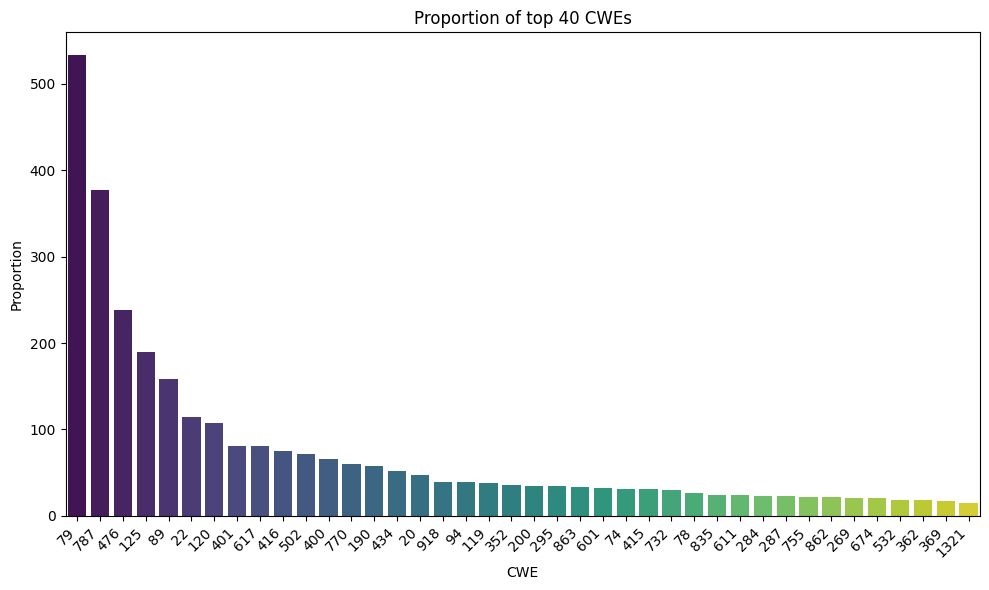

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 40
data = stat_df[stat_df["cve_primary_cwe"].apply(lambda x: x != None)][
    "cve_primary_cwe"
].value_counts(normalize=False)
data_df = data.head(40).reset_index()
data_df.columns = ["CWE", "Proportion"]
print("data len:\t", len(data))
display(data_df.head(10))
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="CWE", y="Proportion", hue="CWE", data=data_df, palette="viridis")

# Add labels and title
plt.xticks(rotation=45, ha="right")
plt.title(f"Proportion of top {k} CWEs")

# Show the plot
plt.tight_layout()
plt.show()

## Creating labels and marge 

In [43]:
positive_df["label"] = True
negative_df["label"] = False

In [47]:
positive_df = positive_df.drop('__index_level_0__', axis=1)

In [48]:
display(positive_df.columns)
display(negative_df.columns)

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_cwe_list',
       'cve_primary_cwe', 'url', 'cve_tags', 'domain', 'issue_owner_repo',
       'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

Index(['issue_owner_repo', 'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

In [49]:
import pandas as pd

positive_df = positive_df.drop(columns=["url", "domain", "cve_cwe_list"])
display(positive_df.columns)
final_df = pd.concat([positive_df, negative_df], axis=0)
final_df.reset_index(drop=True, inplace=True)

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_primary_cwe', 'cve_tags',
       'issue_owner_repo', 'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

In [50]:
display(final_df.columns)
display(final_df)

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_primary_cwe', 'cve_tags',
       'issue_owner_repo', 'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,issue_title,issue_comments_url,issue_comments_count,issue_created_at,issue_updated_at,issue_html_url,issue_github_id,issue_number,label
0,CVE-2012-6685,2020-02-19T15:15:11.723,Nokogiri before 1.5.4 is vulnerable to XXE att...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Issue T...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,776,"[Exploit, Issue Tracking, Third Party Advisory]","(sparklemotion, nokogiri)",Using external xml entities you can specify UR...,nokogiri vulnerable to XXE attack when used un...,https://api.github.com/repos/sparklemotion/nok...,18,2012-06-06 09:34:24,2020-09-23T12:15:38Z,https://github.com/sparklemotion/nokogiri/issu...,4925753,693,True
1,CVE-2013-7469,2019-02-21T03:29:00.243,Seafile through 6.2.11 always uses the same In...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Third P...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,326,[Third Party Advisory],"(haiwen, seafile)",I spent some time auditing the crypto construc...,Encrypted libraries leak lots of information,https://api.github.com/repos/haiwen/seafile/is...,77,2013-09-03 21:27:41,2024-05-23T10:44:30Z,https://github.com/haiwen/seafile/issues/350,18939823,350,True
2,CVE-2014-2906,2020-01-28T16:15:12.133,The psub function in fish (aka fish-shell) 1.1...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Mailing...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,362,[Third Party Advisory],"(fish-shell, fish-shell)",`psub` and `funced` both create temporary file...,psub and funced don't protect tempfiles (CVE-2...,https://api.github.com/repos/fish-shell/fish-s...,0,2014-04-28 02:42:09,2020-04-19T02:03:40Z,https://github.com/fish-shell/fish-shell/issue...,32327861,1437,True
3,CVE-2014-2914,2020-01-28T16:15:12.197,fish (aka fish-shell) 2.0.0 before 2.1.1 does ...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Mailing...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,20,[Third Party Advisory],"(fish-shell, fish-shell)",Before 6d749789ce and 44b35f773 anyone\* could...,Restrict fish_config socket connections (CVE-2...,https://api.github.com/repos/fish-shell/fish-s...,6,2014-04-28 02:43:07,2020-04-19T03:03:23Z,https://github.com/fish-shell/fish-shell/issue...,32327897,1438,True
4,CVE-2014-9470,2020-02-08T17:15:11.247,Cross-site scripting (XSS) vulnerability in th...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,79,[Broken Link],"(forkcms, forkcms)",Link: http://demo.fork-cms.com/en/search?form=...,XSS vulnerability,https://api.github.com/repos/forkcms/forkcms/i...,1,2014-12-25 10:31:18,2014-12-26T07:13:57Z,https://github.com/forkcms/forkcms/issues/1018,52858198,1018,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(mongo-express, mongo-express)","Hello, even though the README file says `ME_CO...",ME_CONFIG_BASICAUTH and ME_CONFIG_BASICAUTH_EN...,https://api.github.com/repos/mongo-express/mon...,3,2025-02-27 23:18:47,2025-05-12T16:53:36Z,https://github.com/mongo-express/mongo-express...,2885807377,1727,False
21798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(mongo-express, mongo-express)",The official **mongo-express:latest** Docker i...,Hardcoded ME_CONFIG_MONGODB_URL Prevents Kuber...,https://api.github.com/repos/mongo-express/mon...,0,2025-02-01 13:30:46,2025-02-01T13:30:46Z,https://github.com/mongo-express/mongo-express...,2825214129,1718,False
21799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(mongo-express, mongo-express)",I'm using mongo-express docker image with foll...,Connect to mongodb without root user not possible,https://api.github.com/repos/mongo-express/

In [102]:
display(final_df.issue_msg.head(3))
final_df[final_df.issue_msg.str.startswith("This is a GitHub Issue\nrepo:MonetDB\nowner:MonetDB\nTitle : MonetDB server 11.46.0 crashes")].issue_msg

0    This is a GitHub Issue\nrepo:jerryscript\nowne...
1    This is a GitHub Issue\nrepo:wasm3\nowner:wasm...
2    This is a GitHub Issue\nrepo:Issues\nowner:Oct...
Name: issue_msg, dtype: object

500      This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
4536     This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
5198     This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
7039     This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
10333    This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
11411    This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
12176    This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
16536    This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
19720    This is a GitHub Issue\nrepo:MonetDB\nowner:Mo...
Name: issue_msg, dtype: object

# Create issue message and embedding

In [52]:
import sys
from pathlib import Path

# Get parent directory (Thesis-Edvin)
sys.path.append(str(Path.cwd().parent))

from utils import *
from datasets import load_dataset

In [54]:
# import genai
import os
import tiktoken
from pandarallel import pandarallel
from utils import load_prompts

pandarallel.initialize(progress_bar=False)
encoding = tiktoken.encoding_for_model("text-embedding-3-large")
prompts_dict = load_prompts("/home/edvinn/KTH/DA231X-ex/Thesis-Edvin/utils" + "/prompts")


def foo(x):
    return prompts_dict["issues_display"].format(
        title=x["issue_title"],
        body=x["issue_body"],
        repo_owner=x["issue_owner_repo"][0],
        repo_name=x["issue_owner_repo"][1],
    )

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [55]:
final_df["issue_msg"] = final_df.parallel_apply(foo, axis=1)
final_df["issue_msg_n_tokens"] = final_df.issue_msg.parallel_map(encoding.encode)
final_df["issue_msg_n_tokens"] = final_df.issue_msg.parallel_map(len)

In [56]:
# remove all entry with a context window > 8191
final_df = final_df[final_df.issue_msg_n_tokens < 8191]

In [ ]:
final_df["cve_primary_cwe"] = final_df["cve_primary_cwe"].fillna("No_CWE")
display(final_df[["cve_primary_cwe"]])

,cve_primary_cwe
0,776
1,326
2,362
3,20
4,79
...,...
21797,No_CWE
21798,No_CWE
21799,No_CWE
21800,No_CWE


In [59]:
stat_df = final_df[final_df.cve_primary_cwe != "No_CWE"]

In [77]:
len(stat_df)

3410

In [63]:
len(stat_df['cve_primary_cwe'].value_counts())
usage_dict_1003 = pd.Series(
    cwe_1003_df.MappingNotes_Usage.values, index=cwe_1003_df.ID
).to_dict()
print(len(stat_df[stat_df['cve_primary_cwe'].isin(usage_dict_1003)])/len(stat_df))

0.9812316715542522


Let's make an estimate of the cost in embedding, (0.02 per 1M tokens)

In [64]:
(final_df.issue_msg_n_tokens.sum() / 1000000) * 0.02

0.66234364

In [65]:
from utils import *

pandarallel.initialize(progress_bar=True, nb_workers=12)


def create_embedding(msg):
    try:
        return (
            client.embeddings.create(input=msg, model="text-embedding-3-large")
            .data[0]
            .embedding
        )
    except Exception as e:
        print(f"Error processing message: {msg}. Error: {e}")
        return None


final_df["issue_embedding"] = final_df.issue_msg.parallel_map(create_embedding)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [66]:
final_df.sample(5)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_comments_count,issue_created_at,issue_updated_at,issue_html_url,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding
21431,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(lovasoa, SQLpage)","When using the hero component, the description...",...,0,2025-02-22 22:08:31,2025-02-22T22:08:31Z,https://github.com/sqlpage/SQLPage/issues/828,2872445526,828,False,This is a GitHub Issue\nrepo:SQLpage\nowner:lo...,1120,"[0.031375665217638016, -0.006388961803168058, ..."
10486,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(mz-automation, libiec61850)","Hello,\r\n\r\nEvinronment: C#\r\nLib version 1...",...,7,2024-03-19 08:12:08,2024-03-20T09:48:12Z,https://github.com/mz-automation/libiec61850/i...,2194303308,498,False,This is a GitHub Issue\nrepo:libiec61850\nowne...,1025,"[-0.01340270321816206, 0.01911277323961258, -0..."
1607,CVE-2021-29325,2021-11-19T17:15:08.113,OpenSource Moddable v10.5.0 was discovered to ...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,787,"[Exploit, Issue Tracking, Patch, Third Party A...","(Moddable-OpenSource, moddable)",# Enviroment\r\n```\r\noperating system: ubunt...,...,0,2021-02-26 10:30:19,2021-03-23T22:52:56Z,https://github.com/Moddable-OpenSource/moddabl...,817236483,582,True,This is a GitHub Issue\nrepo:moddable\nowner:M...,4277,"[-0.03293153643608093, -0.004498655907809734, ..."
20471,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(projectatomic, bubblewrap)",I have a docker container. The container runs ...,...,2,2024-11-25 19:17:37,2024-11-26T13:23:16Z,https://github.com/containers/bubblewrap/issue...,2691929296,673,False,This is a GitHub Issue\nrepo:bubblewrap\nowner...,3317,"[-0.012428168207406998, 0.026435233652591705, ..."
18587,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(xuperchain, xuperchain)",大概问题是我们部署一份合约，已经提示部署成功，但是通过交易hash去查询是查询不到的，如果再...,...,4,2024-11-29 03:10:52,2025-02-11T09:02:42Z,https://github.com/xuperchain/xuperchain/issue...,2703741658,1234,False,This is a GitHub Issue\nrepo:xuperchain\nowner...,310,"[-0.03294115513563156, 0.021434947848320007, -..."


In [67]:
print(len(final_df))

21073


## Create training ad testing split

In [68]:
from sklearn.model_selection import train_test_split


final_df['stratify_label'] = final_df['label'].astype(str) + '_' + final_df['issue_owner_repo'].astype(str)
X_train, X_test = train_test_split(final_df, test_size=0.4, random_state=99, stratify=final_df['label'])


X_train = X_train.drop(columns=['stratify_label'])
X_test = X_test.drop(columns=['stratify_label'])

In [69]:
X_train.label.mean(), X_test.label.mean()

(0.161828679901922, 0.16180308422301304)

In [76]:
print(len(X_train[X_train.cve_primary_cwe != "No_CWE"]))
print(len(X_test[X_test.cve_primary_cwe != "No_CWE"]))

2046
1364


In [70]:
from datasets import Dataset

# train
ds = Dataset.from_pandas(X_train, preserve_index=True)
ds.push_to_hub("Eathus/github-issues-vul-detection-max", split="train")

# test
ds = Dataset.from_pandas(X_test, preserve_index=True)
ds.push_to_hub("Eathus/github-issues-vul-detection-max", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-max/commit/eb02c3209dd195b7e5271a4e2a34a33c25692e5e', commit_message='Upload dataset', commit_description='', oid='eb02c3209dd195b7e5271a4e2a34a33c25692e5e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-max', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-max'), pr_revision=None, pr_num=None)

# Dataset analysis
- t-SNE visualization

In [71]:
from datasets import load_dataset, concatenate_datasets

dataset_repo = "Eathus/github-issues-vul-detection-max"

train_ds = load_dataset(dataset_repo, split="train")
test_ds = load_dataset(dataset_repo, split="test")

combined_ds = concatenate_datasets([train_ds, test_ds])
final_df = combined_ds.to_pandas()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/163M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12643 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8430 [00:00<?, ? examples/s]

In [72]:
import numpy as np

X = final_df[["issue_embedding"]].values
labels = final_df["label"]

data = []
for i in X:
    data.append(i[0])
X = np.array(data)
X.shape

(21073, 3072)

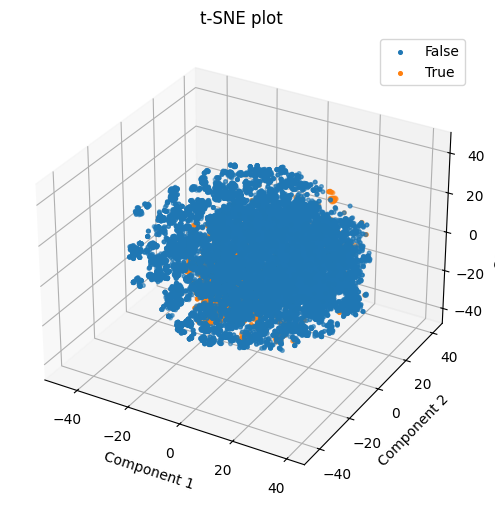

In [73]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)


# Create a DataFrame for the t-SNE result
df_tsne = pd.DataFrame(X_tsne, columns=["Component 1", "Component 2", "Component 3"])
df_tsne["label"] = labels.values

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

for label in df_tsne["label"].unique():
    subset = df_tsne[df_tsne["label"] == label]
    ax.scatter(
        subset["Component 1"],
        subset["Component 2"],
        subset["Component 3"],
        label=label,
        s=7,
    )

ax.set_title("t-SNE plot")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.legend()
plt.savefig("tsne_plot.pdf", format="pdf", bbox_inches="tight")

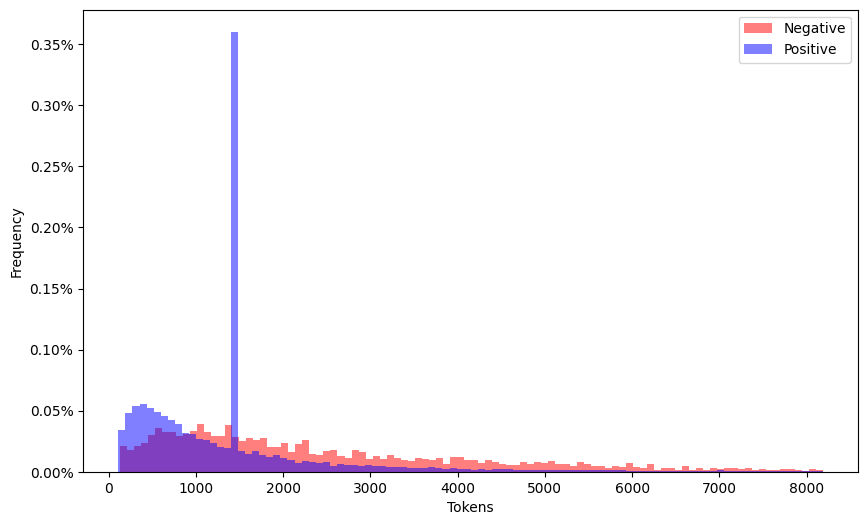

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the histograms

final_df[final_df.label]["issue_msg_n_tokens"].plot.hist(
    bins=100, alpha=0.5, label="Negative", color="red", density=True
)
final_df[~final_df.label]["issue_msg_n_tokens"].plot.hist(
    bins=100, alpha=0.5, label="Positive", color="blue", density=True
)
plt.legend()

plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: "{:.2f}%".format(y * 100))
)
plt.xlabel("Tokens")
plt.savefig("issue_dimension.png", bbox_inches="tight")